In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

In [2]:
sample= pd.read_csv("dataset.csv").to_numpy().ravel()
sample = np.sort(sample)
n = len(sample)
ecdf = ECDF(sample)

In [3]:
def get_distribution_pdf(distribution_name):
    params = eval(f"stats.{distribution_name}.fit")(sample) 
    predicted_distribution = eval(f"stats.{distribution_name}.cdf")(np.sort(sample), *params)
    return predicted_distribution

In [4]:
def get_sse(predicted_sample):
    return np.sum((ecdf.y[1:] - predicted_sample)**2)

def get_mse(sse_value, k):
    return sse_value / (n - k)

def get_aic(sse_value, k):
    return n * np.log(sse_value / n) + (2 * k)

def get_bic(sse_value, k):
    return n * np.log(sse_value / n) + (k * np.log(n))

def get_pc(sse_value, k):
    return (n - k) / 2 * np.log(sse_value / n) + k * (n - 1) / (n - k)

In [5]:
def get_truncated_exponential():
    _, scale = stats.expon.fit(np.sort(sample))
    lamda = 1 / scale
    theta = np.min(ecdf.y)
    predicted_distribution = lamda * np.exp(-lamda * (np.sort(sample) - theta))
    return predicted_distribution

In [6]:
distributions = {
    'expon': 1,
    
    'uniform': 2,
    'norm': 2,
    'lognorm': 2,
    'weibull_min': 2,
    'gamma': 2,
    'rayleigh': 1,
    'beta': 2,
    'two_param_expon': 2,
}
df = pd.DataFrame(columns=['Distribution', 'SSE', 'MSE', 'AIC', 'BIC', 'PC'])
for distribution, k in distributions.items():
    if distribution == 'two_param_expon':
        distribution_predicted = get_truncated_exponential()
    else:
        distribution_predicted = get_distribution_pdf(distribution)
    sse = get_sse(distribution_predicted)
    mse = get_mse(sse, k)
    aic = get_aic(sse, k)
    bic = get_bic(sse, k)
    pc = get_pc(sse, k)
    df.loc[len(df)] = [distribution, sse, mse, aic, bic, pc]


C:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [7]:
df['SSE'].rank(method='first')
df_ranks = pd.DataFrame(columns=['Distribution', 'SSE_Rank', 'MSE_Rank', 'AIC_Rank', 'BIC_Rank', 'PC_Rank'])
for i, col in enumerate(df.iloc[:,1:]):
    df_ranks[col + '_Rank'] = df[col].rank(method='first')
df_ranks['Distribution'] = df['Distribution']

In [8]:
w = [0.1, 0.2, 0.3, 0.3, 0.1]
red_metric = pd.DataFrame(columns=['Distribution', 'RED Value'])
red_value = 0
for i in range(len(df)):
    red_value = 0
    for j in range(1, df.shape[1]-1):
        red_value += np.sqrt((df_ranks.iloc[i,j] / df_ranks.iloc[:,1].sum()) ** 2 + (df.iloc[i,j] / df.iloc[:,1].sum()) ** 2) * w[j]
    red_metric.loc[len(red_metric)] = [df_ranks.iloc[i,0], red_value]
red_metric['Rank'] = red_metric['RED Value'].rank(method='first', ascending=False)

In [9]:
red_metric

,Distribution,RED Value,Rank
0,expon,3.036750,4.0
1,uniform,1.306502,7.0
2,norm,2.824079,6.0
3,lognorm,4.170851,1.0
4,weibull_min,1.122185,8.0
5,gamma,3.832845,2.0
6,rayleigh,2.908864,5.0
7,beta,3.805323,3.0
8,two_param_expon,0.764619,9.0


C:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


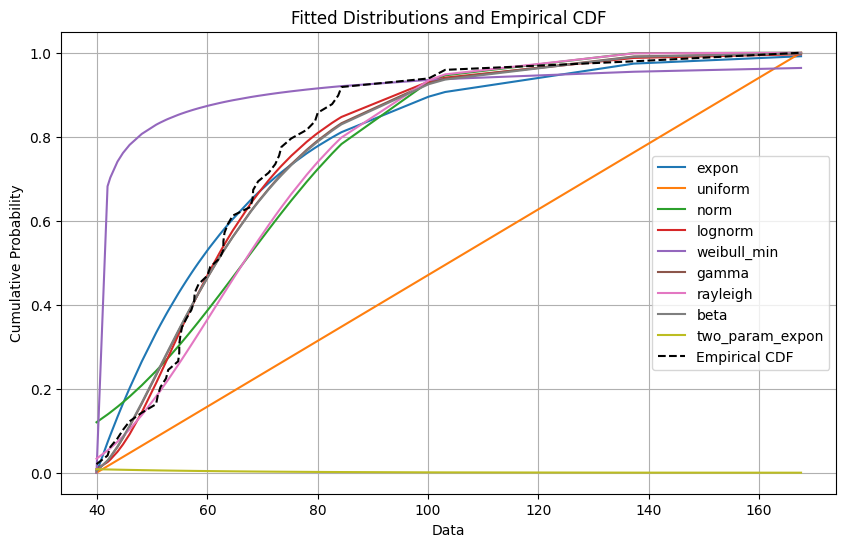

In [10]:
plt.figure(figsize=(10, 6))
# for dist_name in dist_cdf_dict:
#     plt.plot(np.sort(data), dist_cdf, label=dist_name)
for distribution, k in distributions.items():
    if distribution == 'two_param_expon':
        distribution_predicted = get_truncated_exponential()
    else:
        distribution_predicted = get_distribution_pdf(distribution)
    plt.plot(np.sort(sample), distribution_predicted, label=distribution)
plt.plot(ecdf.x, ecdf.y, linestyle='--', color='black', label='Empirical CDF')
plt.xlabel('Data')
plt.ylabel('Cumulative Probability')
plt.title('Fitted Distributions and Empirical CDF')
plt.legend()
plt.grid(True)
plt.show()

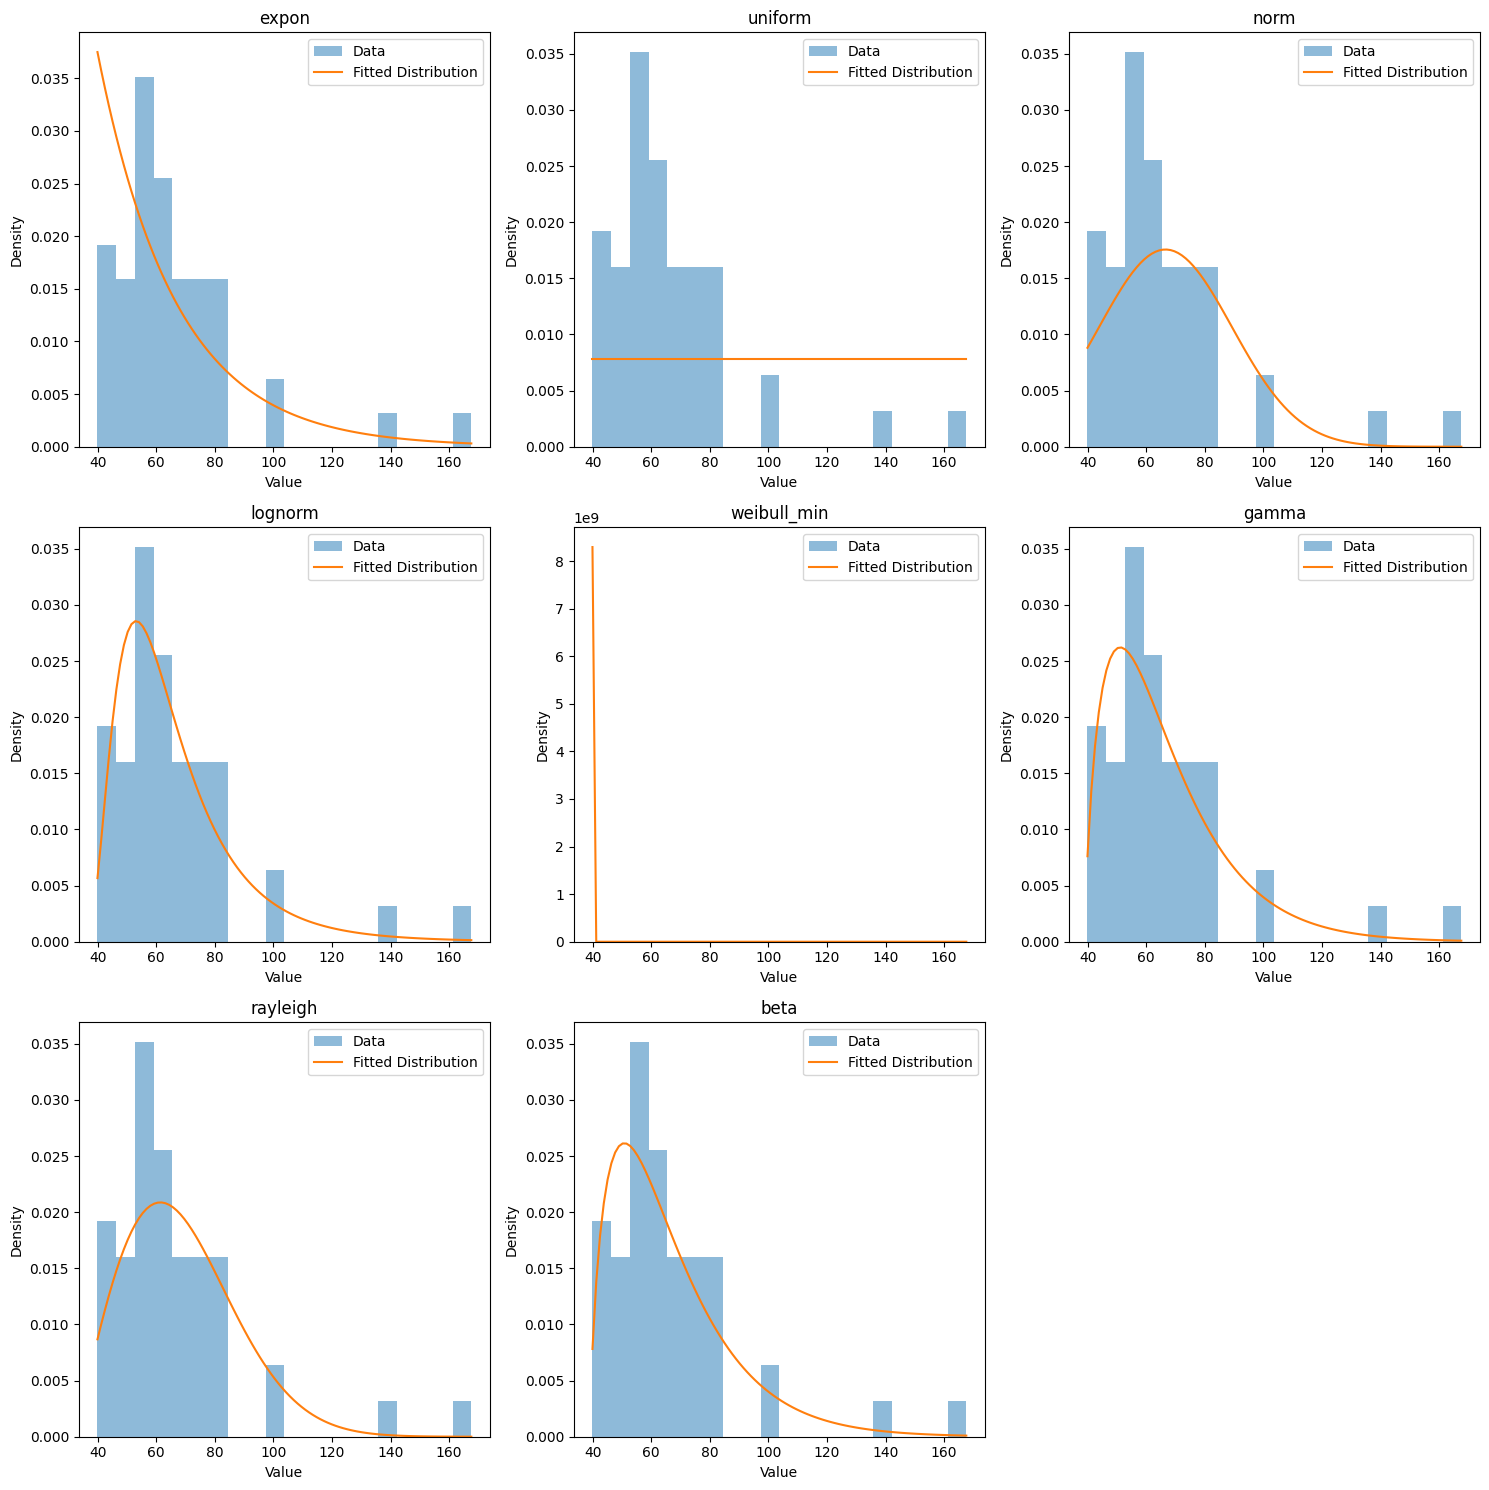

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

fig.delaxes(axes[2, 2])

for ax, (dist_name, _) in zip(axes.flatten(), distributions.items()):
    if dist_name == 'two_param_expon':
        continue
    
    params = eval(f"stats.{dist_name}.fit")(sample) 
    ax.hist(sample, bins=20, density=True, alpha=0.5, label='Data')

    x = np.linspace(min(sample), max(sample), 100)
    y = eval(f"stats.{dist_name}.pdf")(x, *params)

    ax.plot(x, y, label='Fitted Distribution')

    # Add labels and legend
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(dist_name)
    ax.legend()

plt.tight_layout()
plt.show()